##  Libraries

In [52]:
from __future__ import annotations

import pathlib
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import joblib

# Visuals / utils
from visualizations import (
    na_visualization,
    correlation_heatmap,
    plot_feature_importance,
    feature_importance_heatmap,
    plot_pca_variance,
)
from utils import detect_outliers_iqr, build_features, compute_feature_importance


In [53]:
df=pd.read_csv('data\student-data.csv')


# Introduction to the dataset 



Hacer texto explicando 


*** BASIC INFORMATION ***

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-nu

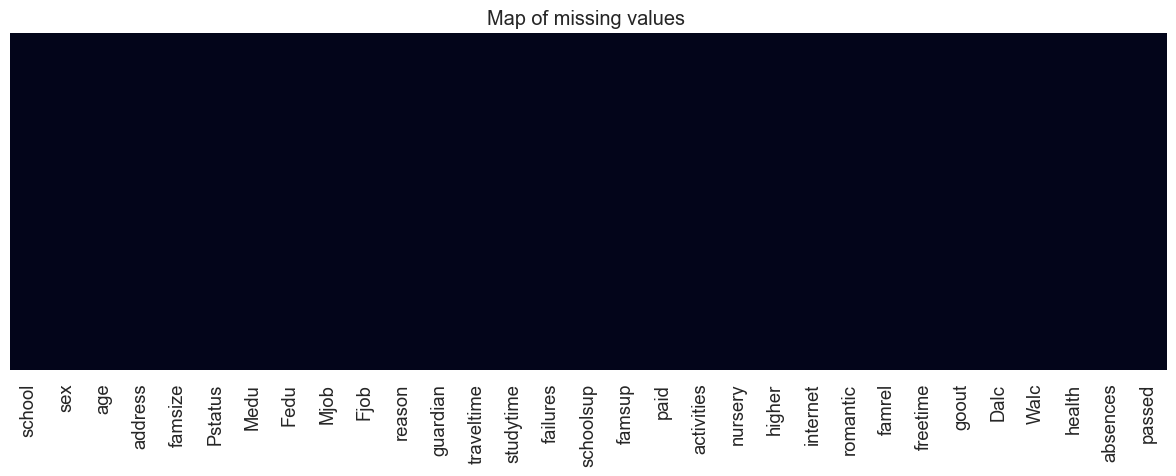

There are no missing values


In [54]:
from visualizations import na_visualization 


print("\n*** BASIC INFORMATION ***\n")
print(df.info())
print("\nShape        :", df.shape)
print("\nNumeric cols :", df.select_dtypes("number").columns.tolist())
print("Categorical  :", df.select_dtypes("object").columns.tolist())
    
na_visualization(df)


We can see from the graphics above t




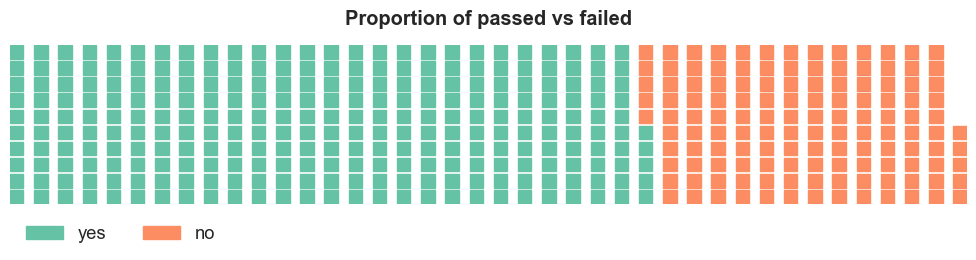

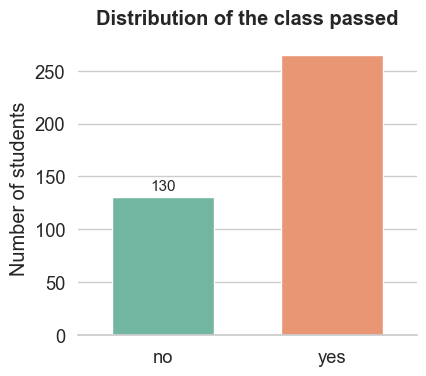

In [55]:
from visualizations import class_distribution
from pywaffle import Waffle
import matplotlib.pyplot as plt  
import seaborn as sns  

# class_distribution(df,True)


# recuentos
counts = df["passed"].value_counts().to_dict()
# paleta con el mismo nº de colores que clases
palette = sns.color_palette("Set2", n_colors=len(counts))  # 2 colores

fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    values=counts,
    colors=palette,
    # -- sin parámetro icons
    legend={'loc':'lower left', 'bbox_to_anchor':(0,-0.35),
            'ncol':2, 'frameon':False},
    interval_ratio_x=0.8,
    figsize=(10,10)
)
plt.title("Proportion of passed vs failed", weight="bold", pad=15)
plt.tight_layout()
plt.show()


sns.set_theme(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(4.5, 4))

# --- 3) barplot -------------------------------
ax = sns.countplot(x="passed",
                   data=df,
                   palette=sns.color_palette("Set2"),
                   width=0.6)

# --- 4) anota las barras ----------------------
ax.bar_label(ax.containers[0], fontsize=11, padding=3)

# --- 5) rótulos & detalles --------------------
ax.set_xlabel("")                            # eje X sin título
ax.set_ylabel("Number of students")
ax.set_title("Distribution of the class passed", pad=12, weight="bold")

sns.despine(left=True)                      # quita spines innecesarios
plt.tight_layout()
plt.show()






### Choice of Class Encoding (pass = 0, fail = 1)
Our label encoding was driven by the operational goal of the project rather than by convenience of the code. The assignment brief explicitly states that “the main goal … is to develop a machine-learning pipeline capable of predicting whether a given student will pass their final exam, thus allowing an intervention system that may flag individual students requiring extra attention and support EIACD_Assignment_2_2024…. In practice, those “individual students” are precisely the ones at risk of failing, so we marked failure as the positive class (1) and success as the negative class (0). This decision has three main advantages:

**Metric focus on the target population.**
Precision, recall, F-score, and the area under the Precision-Recall curve are all computed with respect to the class coded as 1. By assigning fail = 1, these metrics now directly quantify the model’s ability to identify students who need help most urgently.

**Interpretable probabilities for early-warning systems.**
The classifier’s predict_proba() now outputs P(fail) rather than P(pass). Dashboard thresholds can therefore be set on an intuitive “probability of failure” scale (e.g., intervene when risk ≥ 0.30).

**Alignment with class imbalance techniques.**
As the exploratory visualisations show, the dataset is moderately imbalanced: ≈ 260 passes (67 %) vs 130 failures (33 %).
Figure 1 (waffle plot) highlights this skew, and Figure 2 (bar chart) annotates the exact counts.
Treating the minority (failures) as the positive class is standard practice when applying resampling strategies such as SMOTE or ADASYN that the rubric encourages; it maximises the effectiveness of these techniques on the group that matters.

**Why not the opposite mapping?**
Reversing the labels would leave overall accuracy and AUC unchanged, but it would push the minority class into the background of the evaluation, complicating threshold selection and diluting the pedagogical value of the metrics. Given that the primary objective is intervention, not mere forecasting, the chosen encoding provides clearer, action-oriented insights without affecting the mathematical correctness of the models.

In short, coding pass = 0 and fail = 1 turns every subsequent metric and probability into a direct measure of academic risk, fully supporting the intervention philosophy articulated in the project documentation.



### Train/Test Split 

In [56]:
df["passed"] = df["passed"].map({"no": 1, "yes": 0}).astype("int8")
X = df.drop(columns=["passed"])
y = df["passed"]


numeric_cols = X.select_dtypes("number").columns.tolist()
categorical_cols = X.select_dtypes("object").columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("\nSize of Train set      :", X_train.shape)
print("Size of Test set       :", X_test.shape)


Size of Train set      : (316, 30)
Size of Test set       : (79, 30)


# Preprocessing 

Cosas a mencionar  : 

No hay imputacion debido a que no hay ningun NA ni valor faltante

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
101,-0.529411,1.169153,1.333832,-0.635701,1.202930,-0.446388,0.017757,0.705163,-0.102461,-0.527952,-1.004242,0.338061,-0.758644,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
63,-0.529411,1.169153,0.417547,-0.635701,1.202930,-0.446388,-1.104456,0.705163,0.772610,0.599297,1.300895,0.338061,-0.492276,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
245,-0.529411,-0.687391,-1.415022,2.154321,-1.210568,-0.446388,0.017757,-0.276474,-0.102461,-0.527952,-1.004242,0.338061,0.040461,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
112,-0.529411,-0.687391,-0.498737,-0.635701,-0.003819,0.884354,-1.104456,-2.239746,-0.977532,-0.527952,-1.004242,1.055024,0.040461,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
8,-1.311158,0.240881,-0.498737,-0.635701,-0.003819,-0.446388,0.017757,-1.258110,-0.977532,-0.527952,-1.004242,-1.812826,-0.758644,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
53,-1.311158,1.169153,1.333832,-0.635701,-1.210568,-0.446388,-1.104456,-0.276474,0.772610,0.599297,0.532516,1.055024,-0.758644,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
180,-0.529411,1.169153,0.417547,-0.635701,-0.003819,-0.446388,-1.104456,0.705163,-0.102461,0.599297,0.532516,-0.378901,0.573198,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
244,1.034083,-0.687391,-1.415022,0.759310,1.202930,-0.446388,0.017757,0.705163,0.772610,-0.527952,-1.004242,-0.378901,-0.758644,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
352,1.034083,-1.615664,0.417547,-0.635701,-1.210568,0.884354,0.017757,-0.276474,-0.102461,0.599297,0.532516,-0.378901,0.173645,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
221,0.252336,-1.615664,-1.415022,-0.635701,1.202930,0.884354,0.017757,-0.276474,0.772610,-0.527952,-1.004242,1.055024,-0.758644,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0


(316, 56)

Tabla de correlaciones:
                    age  Medu  Fedu  ...  internet_yes  romantic_no  romantic_yes
age                1.00 -0.17 -0.16  ...         -0.10        -0.20          0.20
Medu              -0.17  1.00  0.62  ...          0.23         0.00         -0.00
Fedu              -0.16  0.62  1.00  ...          0.14         0.01         -0.01
traveltime         0.04 -0.22 -0.18  ...         -0.11        -0.02          0.02
studytime          0.01  0.02 -0.05  ...          0.05        -0.04          0.04
failures           0.26 -0.21 -0.26  ...         -0.06        -0.05          0.05
famrel             0.04 -0.00 -0.01  ...         -0.02         0.07         -0.07
freetime          -0.00  0.07 -0.00  ...          0.07         0.02         -0.02
goout              0.14  0.02 -0.00  ...          0.10        -0.01          0.01
Dalc               0.17  0.02 -0.02  ...          0.01        -0.02          0.02
Walc               0.16 -0.05 -0.02  ...         -0.01         

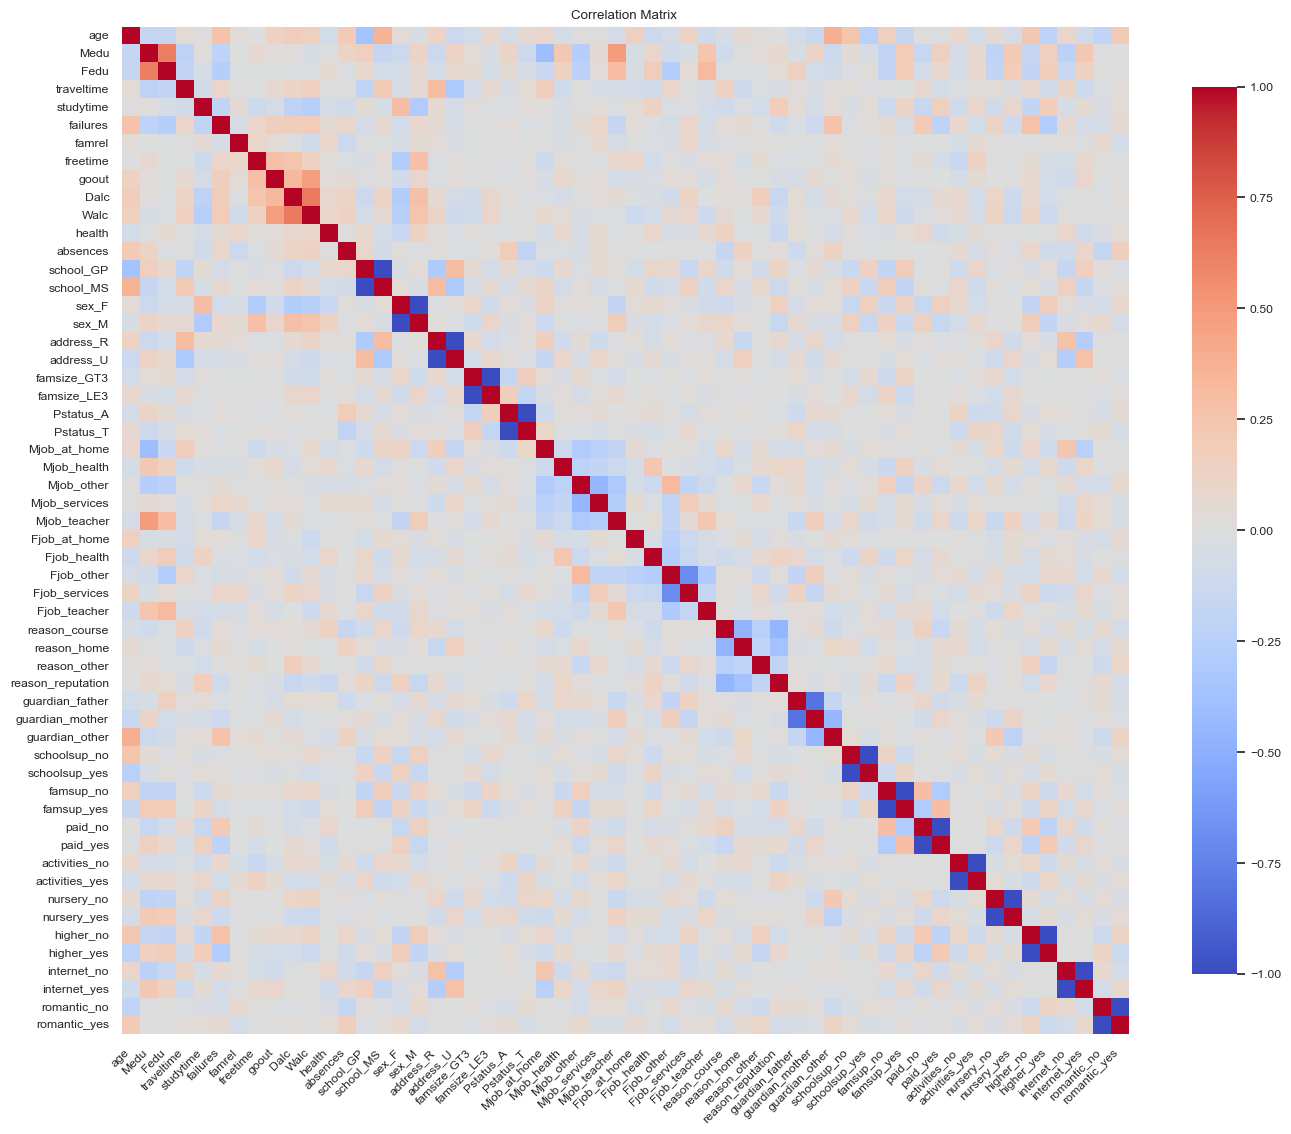

In [ ]:
from utils import detect_outliers_iqr
from importlib import reload 
from visualizations import correlation_heatmap
import visualizations
reload (visualizations)

from sklearn.compose import ColumnTransformer, Function
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# 1) Definición de transformadores
binary_map = lambda: Pipeline([
    ('map', FunctionTransformer(lambda s: s.map({'yes':1,'no':0})))
])

preprocessor = ColumnTransformer([
    # Nominal sin orden
    ('jobs', OneHotEncoder(), ['Mjob','Fjob','guardian']),
    # Ordinal 1–5 o 0–4
    ('ordinal', OrdinalEncoder(), ['Medu','Fedu','famrel','freetime','goout','Dalc','Walc','health','studytime','traveltime']),
    # Binarias sí/no y GP/MS, F/M, U/R, LE3/GT3, T/A
    ('binary', FunctionTransformer(lambda df: df.replace({
        'school':{'GP':0,'MS':1},
        'sex':{'F':0,'M':1},
        'address':{'U':1,'R':0},
        'famsize':{'LE3':0,'GT3':1},
        'Pstatus':{'T':1,'A':0},
        'schoolsup':{'yes':1,'no':0},
        'famsup':{'yes':1,'no':0},
        'paid':{'yes':1,'no':0},
        'activities':{'yes':1,'no':0},
        'nursery':{'yes':1,'no':0},
        'internet':{'yes':1,'no':0},
        'romantic':{'yes':1,'no':0},
    })), ['school','sex','address','famsize','Pstatus','schoolsup','famsup','paid','activities','nursery','internet','romantic']),
    # Numéricas a escalar
    ('num', StandardScaler(), ['age','absences']),
], remainder='passthrough')


# num_cols = X_train.select_dtypes("number").columns.tolist()
# cat_cols = X_train.select_dtypes("object").columns.tolist()

# # Creating transformers for each type
# num_transformer = StandardScaler()
# cat_transformer = OneHotEncoder(handle_unknown='ignore')


# # Define the ColumnTransformer
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', num_transformer, numeric_cols),
#         ('cat', cat_transformer, categorical_cols)
#     ]
# )

X_train_proc=preprocessor.fit_transform(X_train)
X_test_proc=preprocessor.transform(X_test) 

all_feature_names = list(num_cols) + preprocessor.named_transformers_["cat"].get_feature_names_out(cat_cols).tolist()


X_train = pd.DataFrame(X_train_proc, columns=all_feature_names, index=X_train.index)
X_test  = pd.DataFrame(X_test_proc , columns=all_feature_names, index=X_test.index)

display(X_train.head(10))
print(X_train.shape)


correlation_heatmap(X_train)


##  Correlation 

|   |  Par de variables                                                 |  ρ (Pearson) |  ¿Por qué resulta interesante?\*                                                                                                                                                                    |
| -- | ----------------------------------------------------------------- | ------------ | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
|  1 | **Dalc ↔ Walc** (consumo de alcohol entre semana ↔ fin de semana) | **0,65**     | Confirma que el hábito de beber no se restringe a un solo contexto; quienes beben entre semana también tienden a hacerlo con más fuerza los fines de semana. Puede discutirse como señal de riesgo. |
|  2 | **Medu ↔ Fedu** (nivel educativo de la madre ↔ del padre)         | **0,62**     | Muestra fuerte homofilia educacional en la pareja parental; relevante para reflexionar sobre entornos con capital cultural similar y su efecto en el rendimiento.                                   |
|  3 | **goout ↔ Walc** (salir con amigos ↔ alcohol fin de semana)       | **0,47**     | Sugiere que la vida social activa se asocia a mayor consumo recreativo; combina una variable de tiempo libre con una de salud.                                                                      |
|  4 | **Medu ↔ Mjob\_teacher**                                          | **0,45**     | Era esperable que las madres que son profesoras tengan estudios altos, pero cuantificarlo ayuda a justificar por qué “Mjob” puede ser un buen proxy de capital educativo.                           |
|  5 | **Medu ↔ Mjob\_at\_home**                                         | **‑0,41**    | Patrón opuesto al anterior: madres dedicadas al hogar suelen tener menor nivel educativo; contrasta claramente con el punto 4 y refuerza la interpretación.                                         |
|  6 | **age ↔ school\_MS** (edad ↔ colegio Mousinho da Silveira)        | **0,39**     | Indica que el alumnado de MS es ligeramente mayor que el de GP (correlación negativa simétrica con `school_GP`). Puede insinuar políticas de repetición o admisiones tardías.                       |
|  7 | **age ↔ guardian\_other**                                         | **0,39**     | Estudiantes mayores reportan más frecuentemente tutores distintos de madre/padre (p.ej. ellos mismos, abuelos); abre la puerta a hablar de autonomía o situaciones familiares especiales.           |
|  8 | **Fedu ↔ Fjob\_teacher**                                          | **0,35**     | Igual que en las madres, refuerza coherencia interna del dataset y ayuda a validar variables de profesión/educación paternal.                                                                       |


## Feature Engineering 

os dejo la tabla de chapete con las features que saque

| Nº | *Feature*                    | Cómo se construye (pseudo‑código)        | Razonamiento clave                                                                    |
| -- | ---------------------------- | ---------------------------------------- | ------------------------------------------------------------------------------------- |
| 1  | **`study_efficiency_log`**   | `log(studytime + 1) − log(absences + 1)` | Relación horas de estudio / ausencias con escala logarítmica para domar los outliers. |
| 2  | **`absence_ratio`**          | `absences / (traveltime + 1)`            | Penaliza más las faltas de quienes viven cerca de la escuela.                         |
| 3  | **`absence_flag_q75`**       | `1 si absences > P75(absences)`          | Marca a los alumnos con ausencias inusualmente altas tras la limpieza.                |
| 4  | **`alcohol_index_z`**        | `0.4·z(Dalc) + 0.6·z(Walc)`              | Indicador de consumo de alcohol con pesos y escalado *z‑score*.                       |
| 5  | **`alcohol_spike_weekend`**  | `Walc − Dalc`                            | Detecta picos de ocio que pueden interferir con el estudio.                           |
| 6  | **`weekend_focus`**          | `1 si (Dalc ≤ 2 ∧ Walc ≤ 2)`             | Bandera de “buen manejo” del fin de semana.                                           |
| 7  | **`family_support_total`**   | `schoolsup_yes + famsup_yes + paid_yes`  | Suma de apoyos académicos formales e informales (0‑3).                                |
| 8  | **`support_change`**         | `schoolsup_yes − famsup_yes`             | Diferencia ayuda escuela vs. familia: revela discrepancias.                           |
| 9  | **`parent_edu_avg`**         | `(Medu + Fedu) / 2`                      | Capital educativo familiar medio.                                                     |
| 10 | **`highly_educated_parent`** | `1 si max(Medu,Fedu) ≥ 3`                | Basta que un progenitor tenga ≥ secundaria para influir positivamente.                |
| 11 | **`commute_spline_low`**     | `max(0, 2 − traveltime)`                 | Primer segmento del *spline* para capturar efecto no lineal (viajes cortos).          |
| 12 | **`commute_spline_high`**    | `max(0, traveltime − 2)`                 | Segundo segmento del *spline* (viajes largos ≥ 30 min).                               |
| 13 | **`failure_history_std`**    | `z(failures)`                            | Suspensos pasados en escala estándar.                                                 |
| 14 | **`failure_history_sq`**     | `failure_history_std²`                   | Efecto no lineal: el primer suspenso suele pesar más que los siguientes.              |
| 15 | **`fairness_sex_schoolsup`** | `sex_F × schoolsup_yes`                  | Interacción para vigilar posibles sesgos de género en el soporte escolar.             |
| 16 | **`fairness_sex_famsup`**    | `sex_F × famsup_yes`                     | Interacción equivalente con apoyo familiar.                                           |


In [58]:
import utils
reload(utils)
from utils import build_features


train_stats = {
    "q75_absences": X_train["absences"].quantile(0.75),
    "mean_dalc": X_train["Dalc"].mean(),
    "std_dalc": X_train["Dalc"].std(ddof=0) or 1,
    "mean_walc": X_train["Walc"].mean(),
    "std_walc": X_train["Walc"].std(ddof=0) or 1,
    "mean_failures": X_train["failures"].mean(),
    "std_failures": X_train["failures"].std(ddof=0) or 1,
    "median_studytime": X_train["studytime"].median(),
    "median_absences": X_train["absences"].median(),
    "median_traveltime": X_train["traveltime"].median(),
}


X_train = build_features(X_train, train_stats)
X_test = build_features(X_test, train_stats)




## Feature Importance 

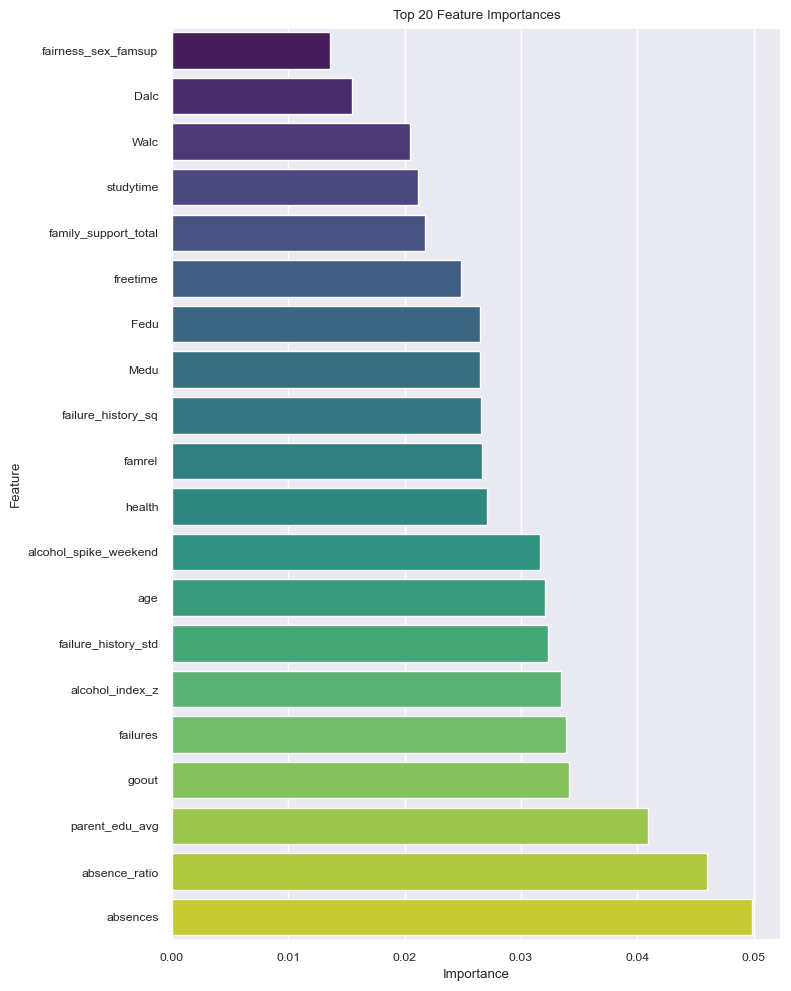

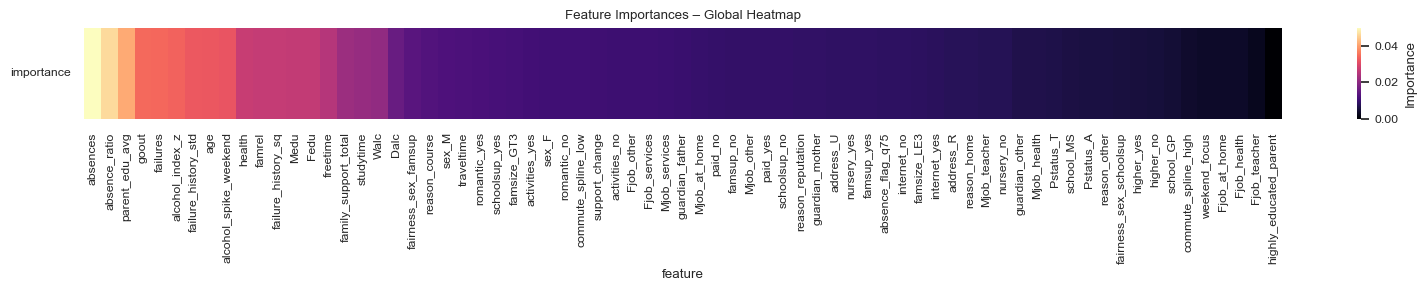

In [59]:
from visualizations import feature_importance_heatmap
importance_df, _ = compute_feature_importance(X_train, y_train)
plot_feature_importance(importance_df, top_n=20)
feature_importance_heatmap(importance_df)


Vemos que hay muchas features sin importancia vamos a ver una reduccion de dimensionalidad para ayudar al coste computacional y facilitar el manejo de memoria al reducir el tamaño de los datos 

## Dimension Reduction 

Explicar brevemente que es el PCA, con formulas y tal

Doing PCA on all preprocessed features …
Components (Kaiser criterion - covariance > mean): 9
  Cumulative variance: 0.7174
Components (Kaiser criterion - correlation > 1): 10
  Cumulative variance: 0.7456
Number of components to reach 97.5% variance: 32


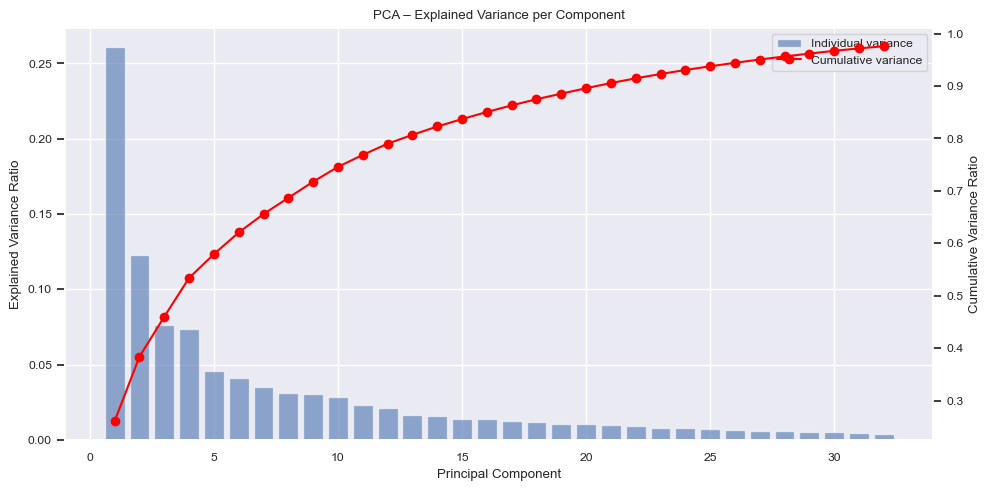

In [60]:

print("Doing PCA on all preprocessed features …")

from utils import preprocess_and_pca

X_train,X_test,pca=preprocess_and_pca(X_train,X_test)
plot_pca_variance(pca.explained_variance_ratio_)



A pesar de los resultados decidimos aumentar el numero de componentes que nos quedabamos con un número de 32



# Model creation  

In [61]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, stratify=y_train, random_state=42
)
print(f"[report] Shapes: X_train={X_train.shape}, X_val={X_val.shape}, X_test={X_test.shape}")

[report] Shapes: X_train=(237, 32), X_val=(79, 32), X_test=(79, 32)


In [62]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

model_params = {
    "logreg": {
        "model": LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42),
        "params": {"C": [0.01, 0.1, 1, 10]},
    },
    "ridge": {
        "model": RidgeClassifier(class_weight="balanced", random_state=42),
        "params": {"alpha": [0.1, 1.0, 10.0]},
    },
    "rf": {
        "model": RandomForestClassifier(class_weight="balanced", random_state=42),
        "params": {"n_estimators": [200, 400], "max_depth": [None, 10, 20]},
    },
    "gb": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {"n_estimators": [100, 200], "learning_rate": [0.01, 0.1], "max_depth": [3, 5]},
    },
    "ada": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {"n_estimators": [50, 100], "learning_rate": [0.01, 0.1, 1]},
    },
    "et": {
        "model": ExtraTreesClassifier(class_weight="balanced", random_state=42),
        "params": {"n_estimators": [100, 200], "max_depth": [None, 10, 20]},
    },
    "xgb": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
        "params": {"n_estimators": [100, 200], "max_depth": [3, 6]},
    },
    "svm": {
        "model": SVC(class_weight="balanced", probability=True, random_state=42),
        "params": {"C": [0.1, 1, 10], "kernel": ["rbf"]},
    },
    "knn": {
        "model": KNeighborsClassifier(),
        "params": {"n_neighbors": [3, 5, 7]},
    },
    "nb": {
        "model": GaussianNB(),
        "params": {},  # Normalmente no tiene hiperparámetros importantes para tunear
    },
    "dt": {
        "model": DecisionTreeClassifier(class_weight="balanced", random_state=42),
        "params": {"max_depth": [None, 10, 20], "min_samples_split": [2, 5, 10]},
    },
    "mlp": {
        "model": MLPClassifier(max_iter=500, random_state=42),
        "params": {"hidden_layer_sizes": [(50,), (100,), (100, 50)], "alpha": [0.0001, 0.001], "learning_rate": ["constant", "adaptive"]},
    },
    
    # "mlp": {
    #     "model": MLPClassifier(max_iter=500, random_state=42),
    #     "params": {
    #         "hidden_layer_sizes": [(50,), (100,), (100, 50), (150, 100, 50)],
    #         "activation": ["relu", "tanh", "logistic"],
    #         "solver": ["adam", "sgd"],
    #         "alpha": [0.0001, 0.001, 0.01],
    #         "learning_rate": ["constant", "invscaling", "adaptive"],
    #         "learning_rate_init": [0.001, 0.01],
    #         "batch_size": [32, 64],
    #     },
    # },
    "lda": {
        "model": LinearDiscriminantAnalysis(),
        "params": {"solver": ["svd", "lsqr"]},
    },
    "qda": {
        "model": QuadraticDiscriminantAnalysis(),
        "params": {},  # Generalmente no se tunea mucho
    },
}

In [63]:
import time
import pandas as pd
from sklearn.model_selection import GridSearchCV

scoring = ['roc_auc', 'f1', 'recall', 'balanced_accuracy']
results = []
best_models = {}

# Diccionario para nombres legibles
model_names = {
    'logreg': 'Logistic Regression',
    'ridge': 'Ridge Classifier',
    'rf': 'Random Forest',
    'gb': 'Gradient Boosting',
    'ada': 'AdaBoost',
    'et': 'Extra Trees',
    'xgb': 'XGBoost',
    'svm': 'SVM',
    'knn': 'K-Nearest Neighbors',
    'nb': 'Gaussian Naive Bayes',
    'dt': 'Decision Tree',
    'mlp': 'Multi-Layer Perceptron',
    'lda': 'Linear Discriminant Analysis',
    'qda': 'Quadratic Discriminant Analysis',
}

for name, mp in model_params.items():
    print(f"Tuning {name}...")
    gs = GridSearchCV(
        estimator=mp["model"],
        param_grid=mp["params"],
        scoring=scoring,
        refit="roc_auc",
        cv=5,
        n_jobs=-1,
    )
    start_time = time.time()
    gs.fit(X_train, y_train)
    elapsed_time = time.time() - start_time

    best_models[name] = gs.best_estimator_

    for metric in scoring:
        results.append({
            'model': name,
            'metric': metric,
            'mean': gs.cv_results_[f'mean_test_{metric}'][gs.best_index_],
            'std': gs.cv_results_[f'std_test_{metric}'][gs.best_index_],
            'time_sec': elapsed_time
        })

# Guardar toda la información
results_df = pd.DataFrame(results)
results_df.to_csv("model_comparison.csv", index=False)

# Crear tabla limpia para imprimir
pivot_df = results_df.pivot(index='model', columns='metric', values=['mean', 'std'])

# Combinar mean ± std en una sola celda
clean_df = pd.DataFrame(index=pivot_df.index)

for metric in scoring:
    clean_df[metric] = pivot_df['mean', metric].round(4).astype(str) + " ± " + pivot_df['std', metric].round(4).astype(str)

# Agregar columna de tiempo (mismo tiempo para todas las métricas → tomamos el primero)
time_df = results_df[['model', 'time_sec']].drop_duplicates().set_index('model')
clean_df['time_sec'] = time_df['time_sec'].round(2)

# Cambiar los índices de abreviación a nombres completos
clean_df.index = clean_df.index.map(model_names)

# Mostrar tabla limpia
display(clean_df)


Tuning logreg...
Tuning ridge...
Tuning rf...
Tuning gb...
Tuning ada...
Tuning et...
Tuning xgb...
Tuning svm...
Tuning knn...
Tuning nb...
Tuning dt...
Tuning mlp...
Tuning lda...
Tuning qda...


,roc_auc,f1,recall,balanced_accuracy,time_sec
model,,,,,
AdaBoost,0.6784 ± 0.0435,0.1198 ± 0.1328,0.0758 ± 0.0918,0.5285 ± 0.0347,1.02
Decision Tree,0.5648 ± 0.0791,0.3871 ± 0.1054,0.3992 ± 0.1327,0.5457 ± 0.0677,0.11
Extra Trees,0.6576 ± 0.0415,0.2743 ± 0.0532,0.1792 ± 0.0459,0.5613 ± 0.0201,0.96
Gradient Boosting,0.627 ± 0.0771,0.4374 ± 0.129,0.3858 ± 0.1241,0.6047 ± 0.0759,3.70
K-Nearest Neighbors,0.5881 ± 0.0813,0.3041 ± 0.0477,0.2308 ± 0.0503,0.5463 ± 0.0291,0.16
Linear Discriminant Analysis,0.607 ± 0.0937,0.4264 ± 0.0909,0.3958 ± 0.0952,0.5879 ± 0.0561,0.03
Logistic Regression,0.625 ± 0.0255,0.4454 ± 0.0495,0.4483 ± 0.079,0.5889 ± 0.029,2.18
Multi-Layer Perceptron,0.5836 ± 0.0538,0.3628 ± 0.0786,0.3467 ± 0.1091,0.5443 ± 0.0386,2.89
Gaussian Naive Bayes,0.6408 ± 0.0432,0.3664 ± 0.0503,0.2692 ± 0.0457,0.5875 ± 0.0219,0.03


## Metrics 

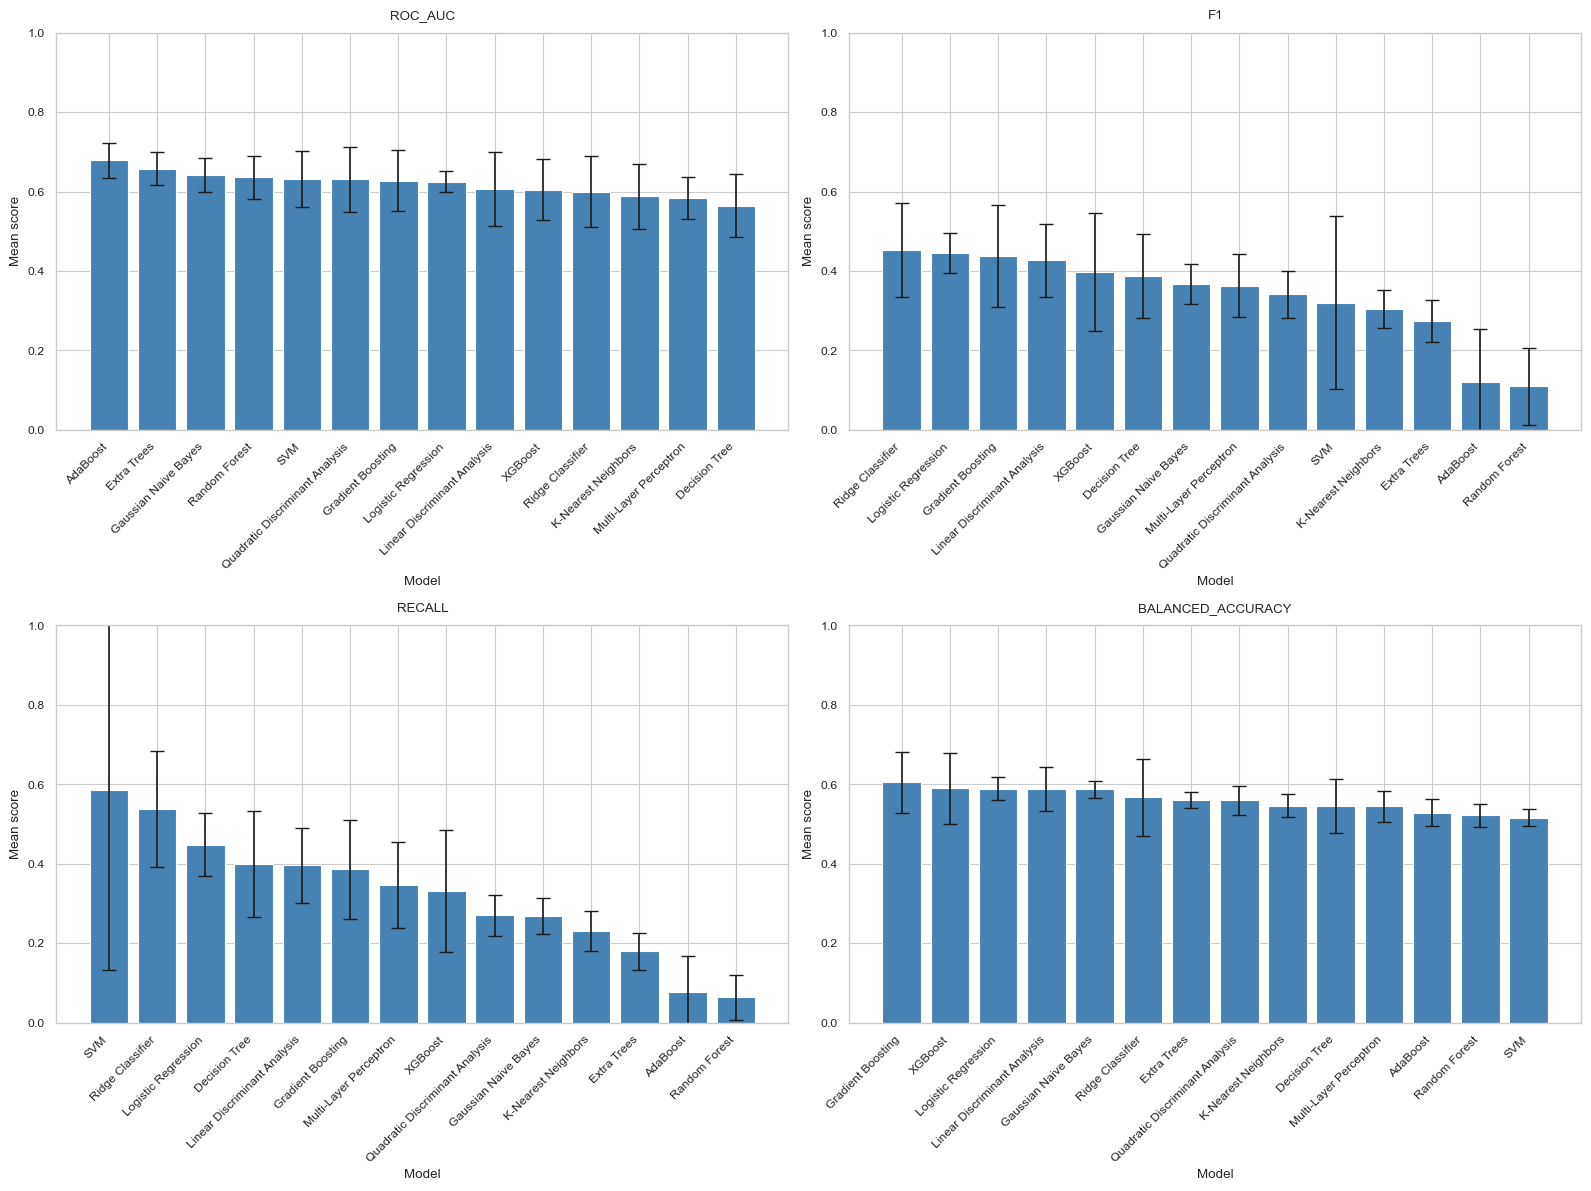

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(context='paper', style='whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes_flat = axes.flatten()
bar_color = 'steelblue'

for ax, metric in zip(axes_flat, scoring):
    dfm = results_df[results_df.metric == metric].copy()
    dfm = dfm.sort_values('mean', ascending=False)
    
    # Reemplazar modelo abreviado por nombre completo
    dfm['model_full'] = dfm['model'].map(model_names)
    
    ax.bar(
        dfm['model_full'], dfm['mean'],
        yerr=dfm['std'], capsize=5,
        color=bar_color
    )
    ax.set_ylim(0, 1)
    ax.set_title(metric.upper(), pad=10)
    ax.set_xlabel('Model')
    ax.set_ylabel('Mean score')
    # Rotar etiquetas del eje x
    ax.set_xticklabels(dfm['model_full'], rotation=45, ha='right')
    
# Ocultar ejes no usados (si sobran)
for ax in axes_flat[len(scoring):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

# Model deployment 

In [65]:
from sklearn.metrics import (
    roc_auc_score, f1_score, recall_score, balanced_accuracy_score,
    confusion_matrix
)

top3_names = (
    results_df[results_df.metric == "f1"]
    .sort_values("mean", ascending=False)
    .head(5)['model']
    .tolist()
)

final_results = []

# Rehacer grid search en train+val y evaluar en test para top 3
for name in top3_names:
    print(f"🔄 Retraining and tuning {model_names[name]} on train+val…")
    gs = GridSearchCV(
        estimator=model_params[name]['model'],
        param_grid=model_params[name]['params'],
        scoring=scoring,
        refit='roc_auc',
        cv=5,
        n_jobs=-1
    )
    gs.fit(X_train, y_train)
    best = gs.best_estimator_

    y_pred = best.predict(X_test)
    y_proba = best.predict_proba(X_test)[:, 1]

    final_scores = {
        'model': name,
        'ROC AUC': roc_auc_score(y_test, y_proba),
        'F1 Score': f1_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred),
    }
    final_results.append(final_scores)

# Crear DataFrame final y mostrar comparativa
final_df = pd.DataFrame(final_results)
final_df['model'] = final_df['model'].map(model_names)
print("\n📊 Test set performance of top 3 models:")
display(final_df.set_index('model').round(4))


# # Gráficos
# sns.set(context='paper', style='whitegrid')
# fig, axes = plt.subplots(2, 2, figsize=(16, 12))
# axes_flat = axes.flatten()
# for ax, metric in zip(axes_flat, scoring):
#     dfm = test_df.copy()
#     dfm = dfm.sort_values(metric, ascending=False)
#     ax.bar(dfm['model_full'], dfm[metric], color='steelblue')
#     ax.set_ylim(0, 1)
#     ax.set_title(metric.upper(), pad=10)
#     ax.set_xlabel('Model')
#     ax.set_ylabel('Score')
#     ax.set_xticklabels(dfm['model_full'], rotation=45, ha='right')
# for ax in axes_flat[len(scoring):]:
#     ax.set_visible(False)
# plt.tight_layout()
# plt.show()


🔄 Retraining and tuning Ridge Classifier on train+val…


AttributeError: 'RidgeClassifier' object has no attribute 'predict_proba'

# Oversampling with SMOTE

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
best_name = (
    results_df[results_df.metric == "f1"]
    .sort_values("mean", ascending=False)
    .iloc[0]["model"]
)
print(f"[report] Applying SMOTE + {model_names[best_name]}")
sm_pipeline = ImbPipeline([
    ("smote", SMOTE(sampling_strategy='auto',random_state=42)),
    (best_name, model_params[best_name]["model"])
])
param_grid_sm = {
    f"{best_name}__{k}": v
    for k, v in model_params[best_name]["params"].items()
}

gs_sm = GridSearchCV(
    im_step := sm_pipeline,
    param_grid=param_grid_sm,
    scoring="f1",
    cv=5,
    refit=True,
    n_jobs=-1,
)
gs_sm.fit(X_train, y_train)
print("[report] Best SMOTE params:", gs_sm.best_params_)
# joblib.dump(gs_sm.best_estimator_, f"smote_{best_name}.joblib")

[report] Applying SMOTE + Extra Trees
[report] Best SMOTE params: {'et__max_depth': 10, 'et__n_estimators': 200}


In [ ]:
sm_model = gs_sm.best_estimator_
sm_pred = sm_model.predict(X_test)
sm_proba = sm_model.predict_proba(X_test)[:, 1]
sm_scores = {
    "roc_auc": roc_auc_score(y_test, sm_proba),
    "f1":      f1_score(y_test, sm_pred),
    "recall":  recall_score(y_test, sm_pred),
    "balanced_accuracy": balanced_accuracy_score(y_test, sm_pred),
}
print("[report] Test set performance after SMOTE:", sm_scores)

[report] Test set performance after SMOTE: {'roc_auc': np.float64(0.6110304789550073), 'f1': 0.7966101694915254, 'recall': 0.8867924528301887, 'balanced_accuracy': np.float64(0.5972423802612482)}


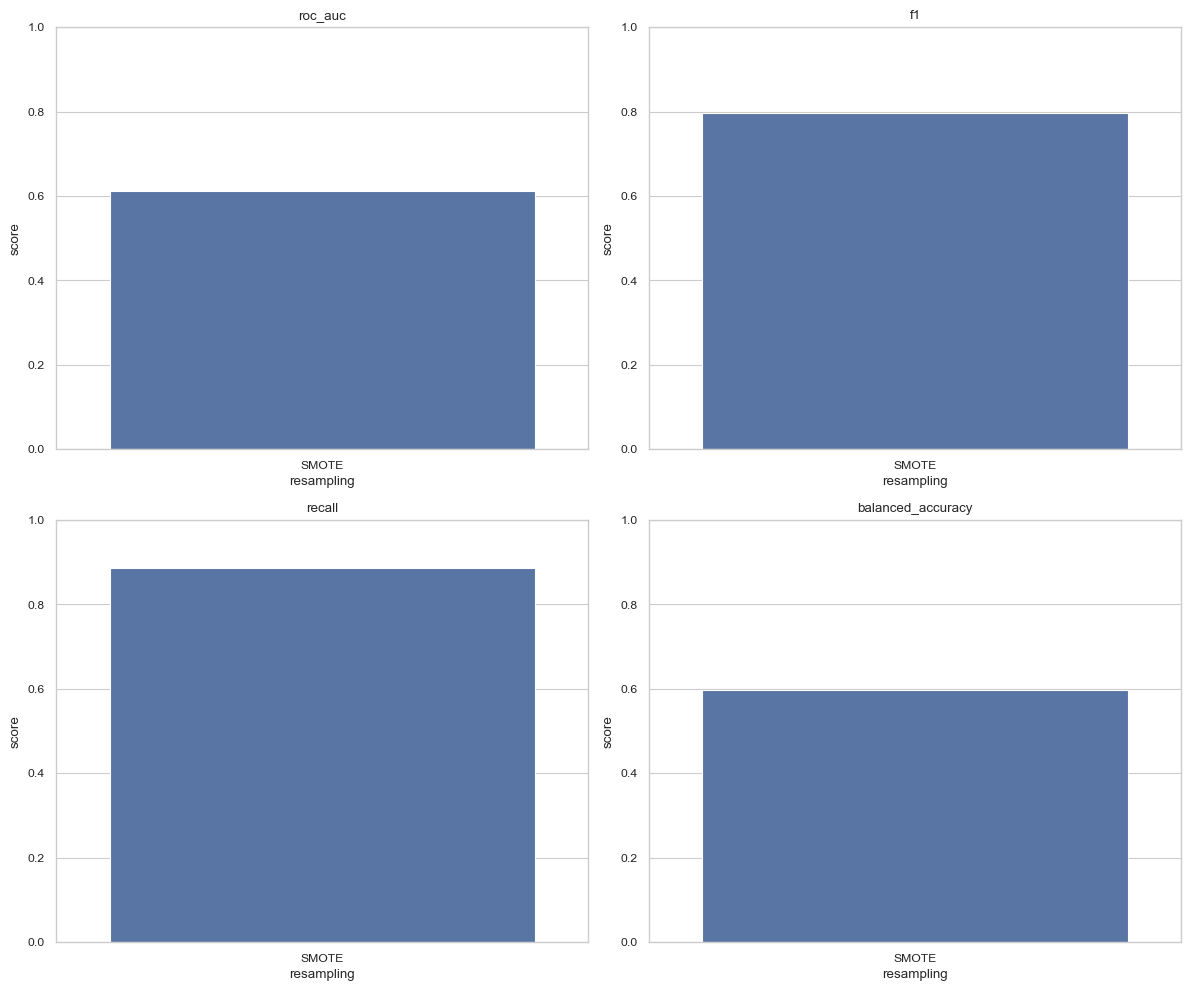

In [ ]:
compare = []
for m, s in final_scores.items():
    compare.append({"metric": m, "resampling": "none", "score": s})
for m, s in sm_scores.items():
    compare.append({"metric": m, "resampling": "SMOTE", "score": s})
cmp_df = pd.DataFrame(compare)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for ax, metric in zip(axes.ravel(), scoring):
    sns.barplot(
        data=cmp_df[cmp_df.metric == metric],
        x="resampling", y="score", ax=ax
    )
    ax.set_title(metric)
    ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

# Conclusion